In [1]:
# Business Case Study

In [50]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import OrdinalEncoder

# for univariate and bivariate analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from phik import phik_from_array, significance_from_array

# selecting the best features
from sklearn.feature_selection import SelectKBest

# model evaluation
from sklearn.model_selection import GridSearchCV, train_test_split

# import the models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# import the metrics
from sklearn.metrics import accuracy_score, RocCurveDisplay, recall_score
from sklearn.metrics import ConfusionMatrixDisplay as cmd

# serializing packages
import pickle

In [4]:
# importing the dataset
df = pd.read_csv('https://raw.githubusercontent.com/zobekenobe/Files/main/wine.csv')

In [5]:
# check the shape of the dataset
df.shape

(1599, 13)

In [6]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Alcohol_content,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Low,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Medium,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Medium,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Medium,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Low,5


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  Alcohol_content       1599 non-null   object 
 12  quality               1599 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 162.5+ KB


In [8]:
# checking for null values 
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Alcohol_content         0
quality                 0
dtype: int64

no null values fortunately

In [9]:
# checking the alcohol content
df['Alcohol_content'].unique()

array(['Low', 'Medium', 'High'], dtype=object)

In [10]:
# checking the quality feature
df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [11]:
# converting the Alcohol_content from a categorical variable to a numerical variable
from sklearn.preprocessing import OrdinalEncoder

In [27]:
encoder = OrdinalEncoder(categories = [['Low', 'Medium', 'High']])
# encoding the data
encoder.fit(df[['Alcohol_content']])

OrdinalEncoder(categories=[['Low', 'Medium', 'High']])

In [28]:
df['Alcohol_content'] = encoder.transform(df[['Alcohol_content']])

In [30]:
# Checking for Multicollinearity
pvalues = []
scores  = []
for col in df.columns[:-1]:
    pvalues.append(significance_from_array(df[col], df['quality'])[0])
    scores.append(phik_from_array(df[col], df['quality']))

In [31]:
temp = pd.DataFrame({"Pvalues":pvalues, "Scores":scores}, index=df.columns[:-1]).sort_values(by="Scores", ascending = False)

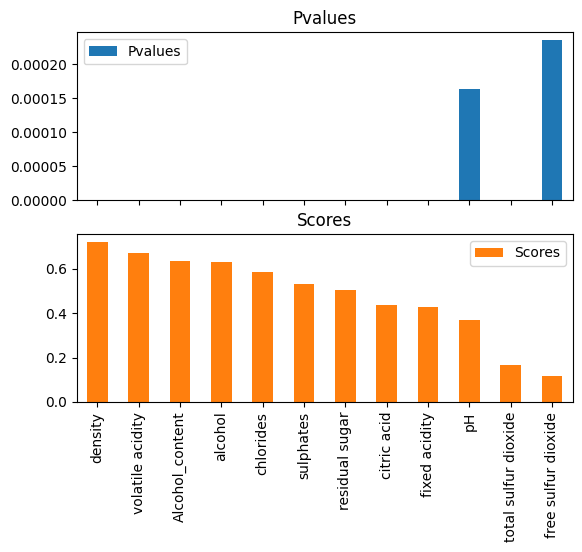

In [35]:
temp.plot.bar(subplots = True)
plt.show()

In [37]:
# checking for the multicollinearity with heathmaps and VIF
vif_score = [vif(df.iloc[:,:-1], i) for i in range(len(df.columns[:-1]))]

In [41]:
temp_vif = pd.DataFrame({'Scores':vif_score}, index=df.columns[:-1]).sort_values(by='Scores', ascending = False)

In [42]:
temp_vif

,Scores
density,1644.322279
pH,1071.002320
alcohol,376.509657
fixed acidity,74.505075
sulphates,21.591842
volatile acidity,17.068848
Alcohol_content,13.658526
citric acid,9.183637
chlorides,6.597278
total sulfur dioxide,6.552697


apparently the vif scores of all the features but 1 is greater than 5, hence indicating a high correlation between the features.hence we can now use the heatmap to indentify the correlations


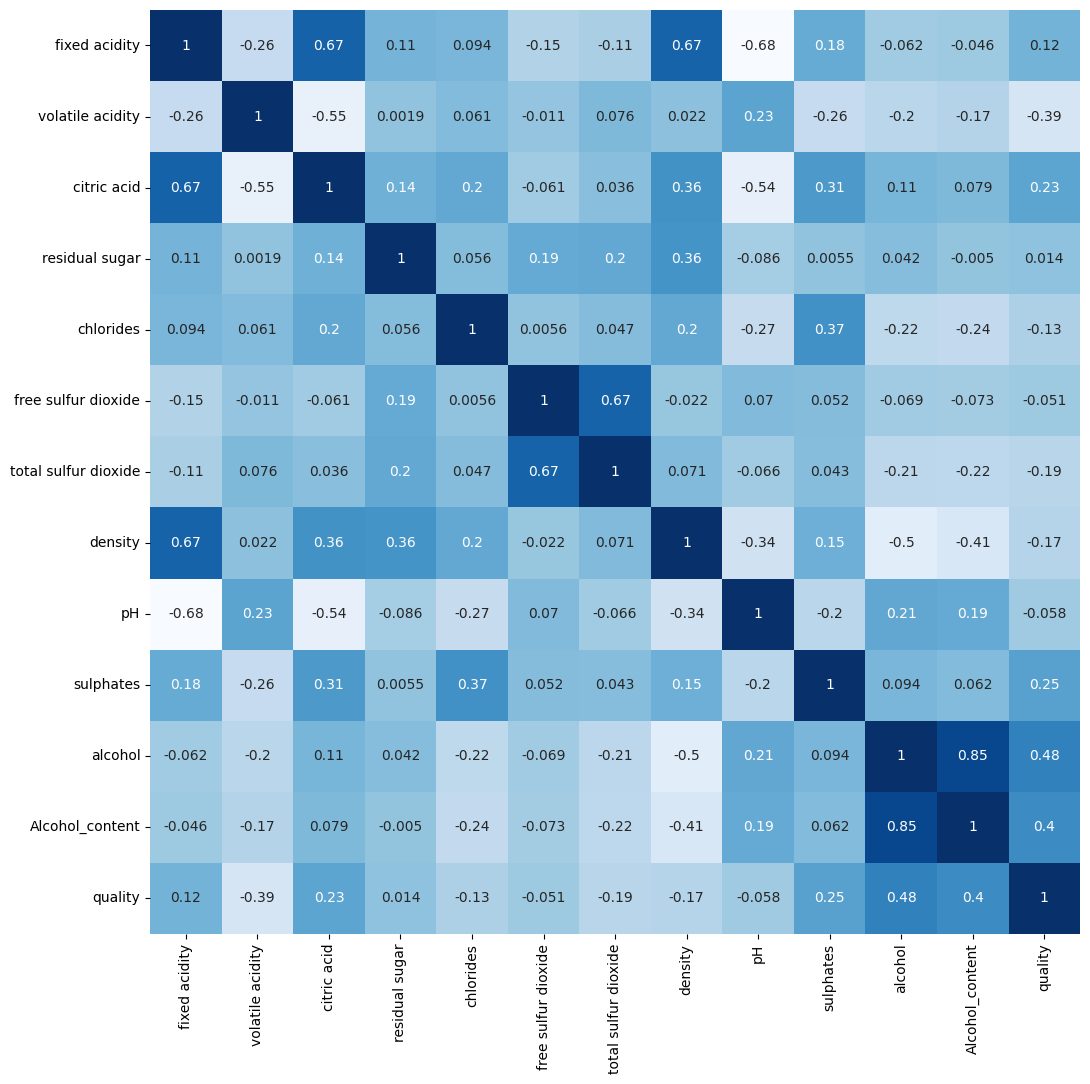

In [48]:
plt.figure(figsize = (12,12))
sns.heatmap(df.iloc[:,:].corr(), cmap = 'Blues', annot = True, cbar=False)
plt.show()

from the above, the alcohol_content and alcohol have a strong correlation and the former has a smaller correlation with the target variable; quality, hence we drop this feature 

In [60]:
x = df.drop(columns = ['quality', 'Alcohol_content'])
y = df['quality'].map(lambda x : 0 if x<6 else 1)

In [62]:
# split the dataset into a training and testing data
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [63]:
# instantiating the different models
lr = LogisticRegression(max_iter=10000)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

In [64]:
# training the models
lr.fit(xtrain, ytrain)
dt.fit(xtrain, ytrain)
rf.fit(xtrain, ytrain)

RandomForestClassifier()

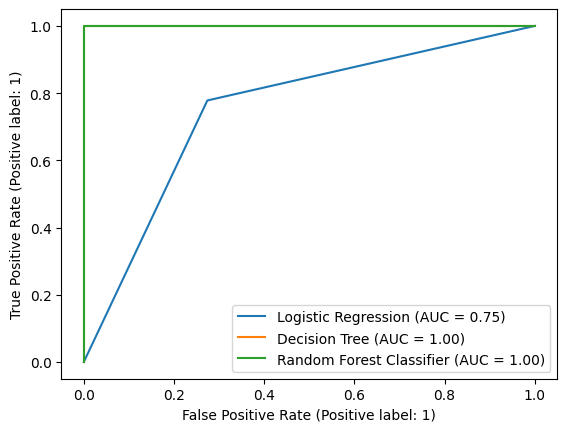

In [66]:
# comparing the models
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(lr.predict(xtrain), ytrain, ax = ax, name='Logistic Regression')
RocCurveDisplay.from_predictions(dt.predict(xtrain), ytrain, ax = ax, name="Decision Tree")
RocCurveDisplay.from_predictions(rf.predict(xtrain), ytrain, ax = ax, name="Random Forest Classifier")

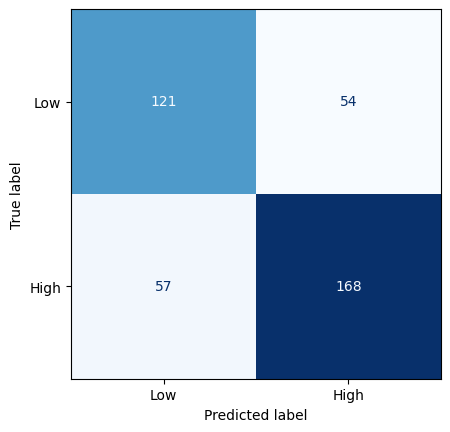

Recall_score  : 0.747
Accuracy Score: 0.723


In [74]:
# we'll use the decision tree classifier
cmd.from_predictions(dt.predict(xtest), ytest, cmap='Blues', colorbar=False, display_labels=['Low', 'High'])
plt.show()
print(f"Recall_score  : {recall_score(dt.predict(xtest), ytest):0.3f}")
print(f"Accuracy Score: {accuracy_score(dt.predict(xtest), ytest):0.3f}")

In [76]:
# using GridSearchCV for hyperparameter tuning
param_grid = {"criterion" : ['gini', 'entropy', 'log_loss'], "max_depth":range(10, 15), "min_samples_leaf":range(2, 8), "min_samples_split":range(3, 8)}

In [77]:
gcd = GridSearchCV(estimator = dt, param_grid = param_grid, n_jobs=-1, cv = 5)

In [78]:
gcd.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(10, 15),
                         'min_samples_leaf': range(2, 8),
                         'min_samples_split': range(3, 8)})

In [79]:
best_model = gcd.best_estimator_

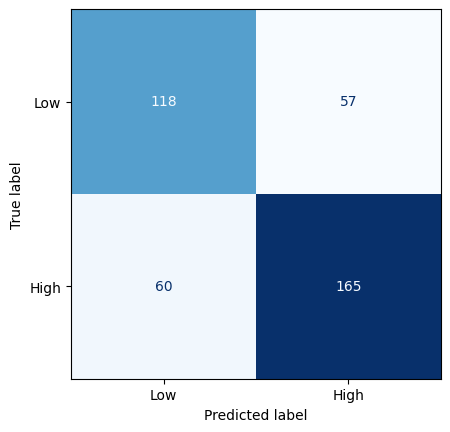

Recall_score  : 0.733
Accuracy Score: 0.708


In [82]:
# now checking the metrics on the testing dataset to see any improvements

cmd.from_predictions(best_model.predict(xtest), ytest, cmap='Blues', colorbar=False, display_labels=['Low', 'High'])
plt.show()
print(f"Recall_score  : {recall_score(best_model.predict(xtest), ytest):0.3f}")
print(f"Accuracy Score: {accuracy_score(best_model.predict(xtest), ytest):0.3f}")

In [83]:
# using the default parameters we save the model
with open("wine.pkl", 'wb') as f:
    pickle.dump([encoder, dt], f)